In [2]:
import KeyFunctions as kf

root_path = "D:/GeoData/"
Main_CRS = "EPSG:27700"

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#Import the postcode list from the raw data gdf
name = "StPauls" 
gdf = kf.load_obj(root_path,"raw_gdf_" + name)

In [8]:
#Initial set up os selecting some points and polygons
all_gb = gdf.loc[gdf["Type"]=="All_GB",:]
poly = gdf.loc[gdf["Type"]=="Road",:]

points = gdf.loc[gdf["Type"]=="RailwayStations",:]
point = points.iloc[9,:]

In [9]:
#Draw a 1km circle and find the polygons intersecting this circle

#add buffer of 1km to the point
#find the outside of the circle for plotting
point_bf = point.geometry.buffer(1000)
x,y = point_bf.exterior.xy

#find the poly in the circle
n = poly["geometry"].intersection(point_bf)
inside = poly[~n.is_empty]
outside = poly[n.is_empty]

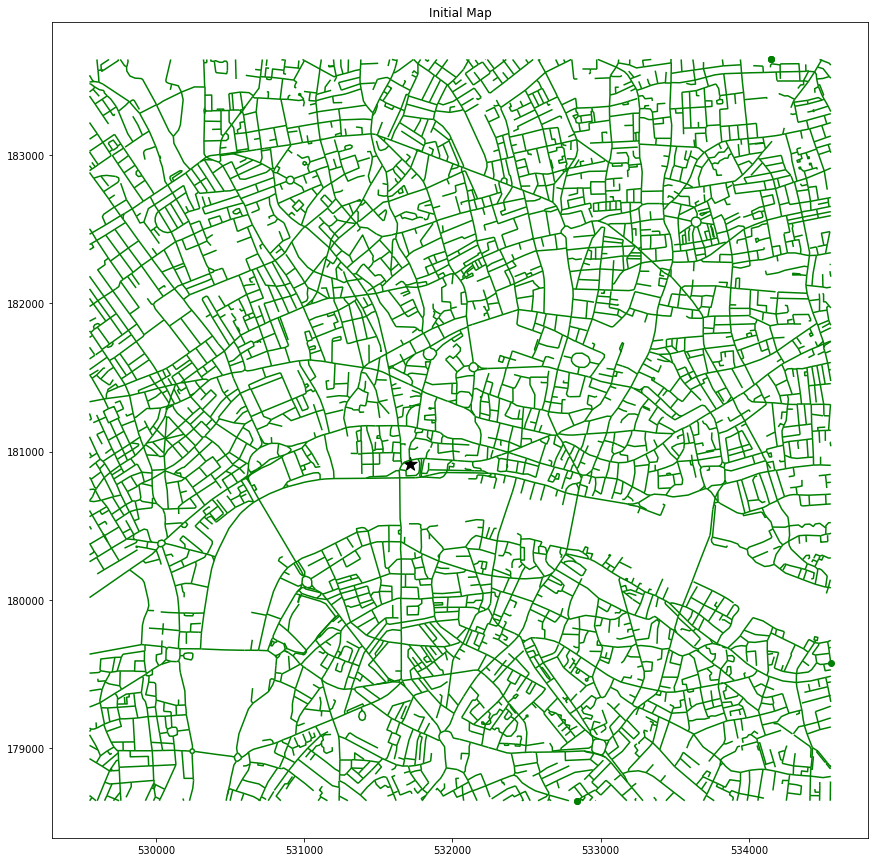

In [10]:
#Draw a map of the polygons and the point
fig, ax = plt.subplots(1, figsize=(15,15))
plt.title("Initial Map")
#all_gb.plot(ax=ax, color='none', edgecolor='black')
poly.plot(ax=ax, color='green')
plt.scatter(point.geometry.x,point.geometry.y,c="black", marker='*',s=200)
plt.show()

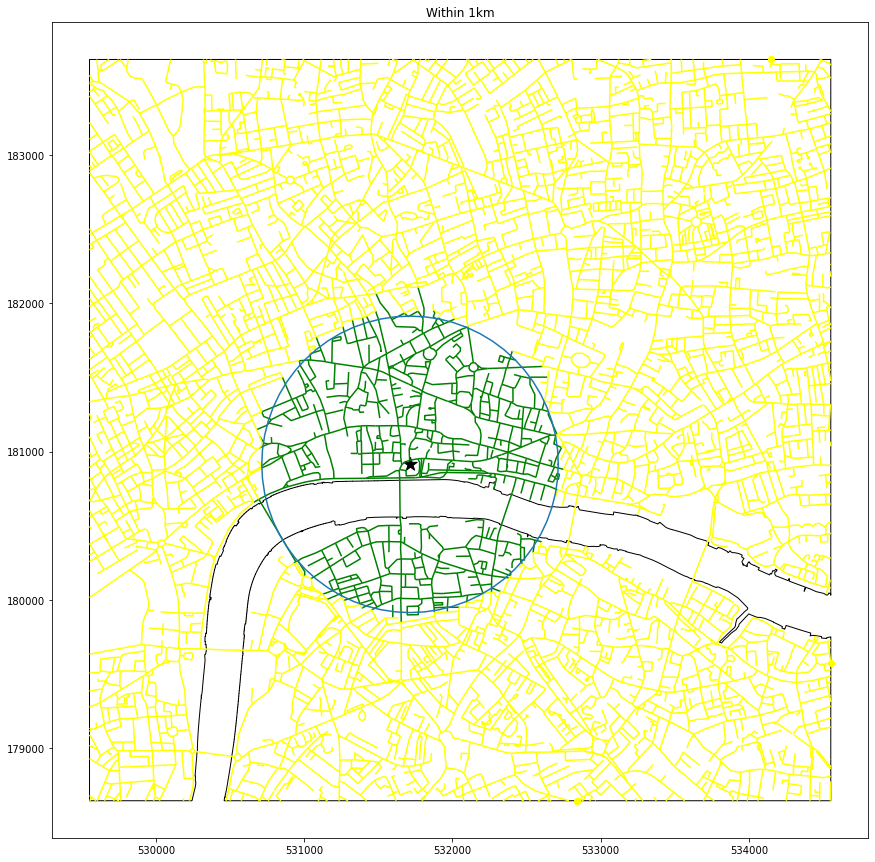

In [11]:

#Draw a map of the point and the polygons with part within 1km
fig, ax = plt.subplots(1, figsize=(15,15))
plt.title("Within 1km")
all_gb.plot(ax=ax, color='none', edgecolor='black')
inside.plot(ax=ax, color='green')
outside.plot(ax=ax, color='yellow')
plt.plot(x,y)
plt.scatter(point.geometry.x,point.geometry.y,c="black", marker='*',s=200)
plt.show()

In [12]:
#First way to find the nearest polygon
poly.geometry.distance(point.geometry).min()

#But this won't scale well

26.449212943807698

In [13]:
#Second method: deconstruct the functions found here https://gps2space.readthedocs.io/en/latest/measuring_distance.html to find nearest 

spatial_index = poly.sindex

bbox = point.geometry.buffer(1000, cap_style=3)
possible_matches_index = list(spatial_index.intersection(bbox.bounds))

poly.iloc[possible_matches_index].distance(point.geometry).min()

#this took longer on this small dataframe but should scale better


26.449212943807698

In [14]:
# Get the geometry so it can be plotted
possible_matches = poly.iloc[possible_matches_index]
possible_matches["dist"] = possible_matches.distance(point.geometry)
nearest = possible_matches.loc[possible_matches["dist"] == possible_matches["dist"].min(),:]

C:\Users\richa\Anaconda3\envs\GeoData\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


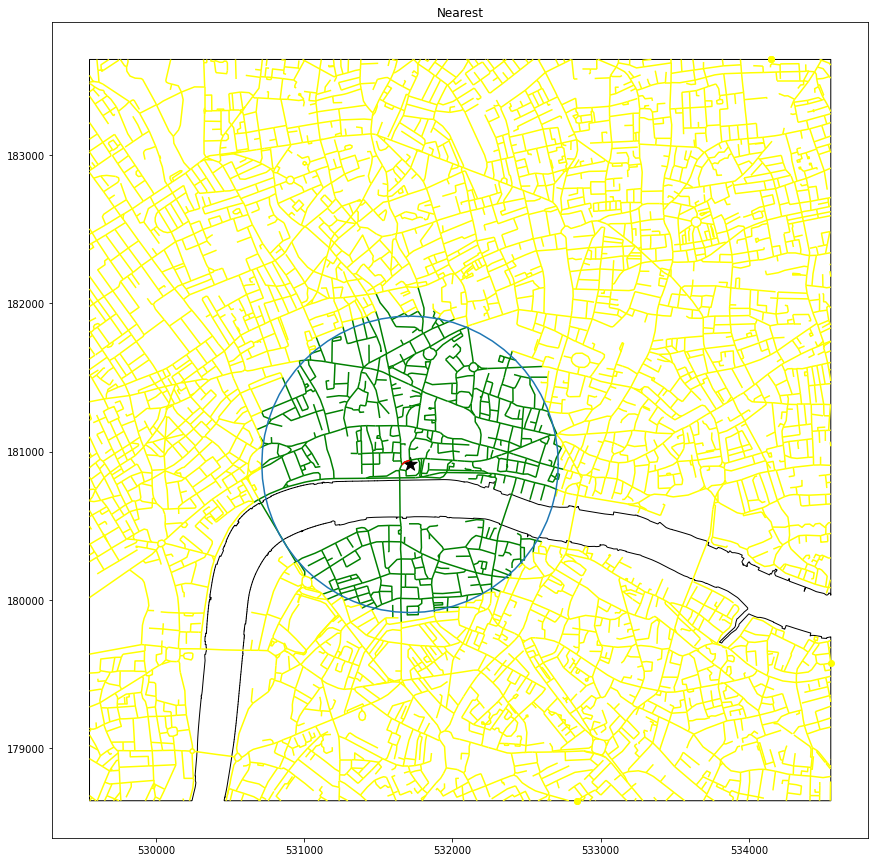

In [15]:
#Draw a map of the point and the polygons with part within 1km
fig, ax = plt.subplots(1, figsize=(15,15))
plt.title("Nearest")
all_gb.plot(ax=ax, color='none', edgecolor='black')
inside.plot(ax=ax, color='green')
outside.plot(ax=ax, color='yellow')
nearest.plot(ax=ax, color='red')
plt.plot(x,y)
plt.scatter(point.geometry.x,point.geometry.y,c="black", marker='*',s=200)
plt.show()

In [118]:
def closest_poly(x, gdf_target, spatial_index, search_radius=None):

	"""
	Detect the nearest polygons based on SEARCH_RADIUS (buffer size)
	Parameters
	==========
	gdf_target: The GeoDataFrame from which you want to find the nearest polygons
	spatial_index: Spatial index of the gpd_target GeoPandas dataframe
	search_radius: Search radius, i.e., the buffer size to buffer point features
	Returns
	=======
	xxx: xxx
	"""

    # SEARCH_RADIUS in meters
	search_radius = search_radius
	bbox = x.buffer(search_radius, cap_style=3)
	possible_matches_index = list(spatial_index.intersection(bbox.bounds))

    # If no intersection, return NaN
	if len(possible_matches_index) == 0:
		return None

    # If has intersections, return the minimum distance
	else:
		possible_matches = gdf_target.iloc[possible_matches_index]
		return possible_matches.distance(x).min()

def dist_to_poly(gdf_source, gdf_target, search_radius, proj=Main_CRS):
	"""
	Perform the nearest distance measures from a source GeoPandas dataframe to a target GeoPandas dataframe
	Parameters
	==========
	gdf_souruce: The source GeoDataFrame contains point features
	gpd_target: The GeoDataFrame from which you want to find the nearest polygons from the gdf_source
	proj: Projection system
	search_radius: Search radius, i.e., the buffer size to buffer point features
	Returns
	=======
	gdf: GeoDataFrame
	"""
    # Project GeoPandas dataframe and copy gdf_source
	gdf_source = gdf_source.to_crs(proj).copy()
	gdf_target = gdf_target.to_crs(proj)

    # If SEARCH_RADIUS is not specified, iterate over all the features
	if not search_radius:
		print("No search radius is specified, the calculation may take longer time for datasets in large volumes.")
		out = gdf_source.geometry.apply(lambda x: gdf_target.distance(x).min())

    # If SEARCH_RADIUS is specified, keep those only within SEARCH_RADIUS, otherwise, make NaN
	else:
		print("A search radius of " + str(search_radius) + 
		      " meters is specified. Points with no neighbors intersected " +
		      "with the search radius will return NaN.")
		spatial_index = gdf_target.sindex
		out = gdf_source.geometry.apply(lambda x: closest_poly(x, gdf_target, spatial_index, search_radius))

	return out

#I've added to give a count within a radius
def within_radius(x, gdf_target, spatial_index, search_radius):

	"""
	Detect the nearest polygons based on SEARCH_RADIUS (buffer size)
	Parameters
	==========
	gdf_target: The GeoDataFrame from which you want to find the nearest polygons
	spatial_index: Spatial index of the gpd_target GeoPandas dataframe
	search_radius: Search radius, i.e., the buffer size to buffer point features
	Returns
	=======
	xxx: xxx
	"""

    # SEARCH_RADIUS in meters
	search_radius = search_radius
	bbox = x.buffer(search_radius, cap_style=3)
	possible_matches_index = list(spatial_index.intersection(bbox.bounds))

    # If no intersection, return NaN
	if len(possible_matches_index) == 0:
		return None

    # If has intersections, return the minimum distance
	else:
		possible_matches = gdf_target.iloc[possible_matches_index]
		return len(possible_matches)

def poly_within_r(gdf_source, gdf_target, search_radius, proj=Main_CRS):
	gdf_source = gdf_source.to_crs(proj)
	gdf_target = gdf_target.to_crs(proj)
	gdf_count = gdf_source.copy()

	spatial_index = gdf_target.sindex
	out = gdf_source.geometry.apply(lambda x: within_radius(x, gdf_target, spatial_index, search_radius))
	return out

In [119]:
dist_to_poly(points, poly, 1000)

A search radius of 1000 meters is specified. Points with no neighbors intersected with the search radius will return NaN.


2086    163.206968
2087    138.026305
2089    120.304451
2091    108.628265
2095    165.277713
2111    125.254186
2115     17.401529
2122     88.050638
2127    264.150118
2128    313.901565
2137     74.440265
2148      0.000000
2149    272.965052
2150    116.744379
2156    224.566722
2157    220.617797
2163    130.547953
2166    111.276688
2173     44.183746
2174      3.932099
Name: geometry, dtype: float64

In [120]:
poly_within_r(points, poly, 1000)

2086    48
2087    48
2089    50
2091    22
2095    60
2111    55
2115    56
2122    66
2127    31
2128    37
2137    84
2148    34
2149    51
2150    68
2156    66
2157    66
2163    54
2166    42
2173    75
2174    67
Name: geometry, dtype: int64

In [121]:
#test on a big dataframe now
gdf = kf.load_obj(root_path,"raw_gdf")

In [124]:
poly = gdf.loc[gdf["Type"]=="GreenSpace",:]
points = gdf.loc[gdf["Type"]=="Postcodes",:]

In [125]:
dist_to_poly(points, poly, 1000)

A search radius of 1000 meters is specified. Points with no neighbors intersected with the search radius will return NaN.


In [ ]:
poly_within_r(points, poly, 1000)

0       36.0
1       12.0
2        8.0
3        7.0
4        6.0
        ... 
2628     7.0
2629    15.0
2630    33.0
2631    22.0
2632    13.0
Name: geometry, Length: 2633, dtype: float64